In [9]:
import pandas as pd
df = pd.read_csv('/content/Pakistan Earthquake Data 1975-2025.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       286 non-null    object 
 1   time       286 non-null    object 
 2   latitude   286 non-null    float64
 3   longitude  286 non-null    float64
 4   depth_km   286 non-null    float64
 5   magnitude  286 non-null    float64
 6   place      286 non-null    object 
 7   type       286 non-null    object 
dtypes: float64(4), object(4)
memory usage: 18.0+ KB


In [3]:
import pandas as pd
import re

df =  pd.read_csv("/content/Pakistan Earthquake Data 1975-2025.csv")


def normalize_place_field(place_text):
    """
    Parse place field into distance, direction, district, and country
    Expected format: "X km DIRECTION of DISTRICT, COUNTRY"
    """

    pattern = r'(\d+)\s*km\s+([NSEW]{1,3})\s+of\s+([^,]+),\s*(.+)'

    match = re.match(pattern, place_text.strip())

    if match:
        distance = int(match.group(1))
        direction = match.group(2)
        district = match.group(3).strip()
        country = match.group(4).strip()

        return {
            'distance': distance,
            'direction': direction,
            'district': district,
            'country': country
        }
    else:
        # Handle cases that don't match the expected pattern
        return {
            'distance': None,
            'direction': None,
            'district': None,
            'country': place_text
        }

# Process the data - apply normalization to the 'place' column
normalized_places = df['place'].apply(normalize_place_field)


place_df = pd.DataFrame(list(normalized_places))

# Add the normalized columns to the original dataframe
df_normalized = pd.concat([df, place_df], axis=1)

print("Sample of Normalized Data:")
print("=" * 80)
print(df_normalized[['place', 'distance', 'direction', 'district', 'country']].head(10).to_string(index=False))

print("\n\nFull Dataset Info:")
print("=" * 40)
print(f"Total records: {len(df_normalized)}")
print(f"Successfully parsed: {df_normalized['distance'].notna().sum()}")
print(f"Failed to parse: {df_normalized['distance'].isna().sum()}")


failed_records = df_normalized[df_normalized['distance'].isna()]
if len(failed_records) > 0:
    print(f"\nRecords that failed to parse:")
    print(failed_records[['place']].to_string(index=False))

print("\n\nUnique Countries:")
print(df_normalized['country'].unique())

print("\n\nUnique Directions:")
print(sorted(df_normalized['direction'].dropna().unique()))

print("\n\nDistance Statistics:")
print(f"Min: {df_normalized['distance'].min()} km")
print(f"Max: {df_normalized['distance'].max()} km")
print(f"Mean: {df_normalized['distance'].mean():.1f} km")
print(f"Median: {df_normalized['distance'].median():.1f} km")

# Direction mapping for better understanding
direction_map = {
    'N': 'North',
    'S': 'South',
    'E': 'East',
    'W': 'West',
    'NE': 'Northeast',
    'NW': 'Northwest',
    'SE': 'Southeast',
    'SW': 'Southwest',
    'NNE': 'North-Northeast',
    'ENE': 'East-Northeast',
    'ESE': 'East-Southeast',
    'SSE': 'South-Southeast',
    'SSW': 'South-Southwest',
    'WSW': 'West-Southwest',
    'WNW': 'West-Northwest',
    'NNW': 'North-Northwest'
}

print("\n\nDirection Breakdown:")
direction_counts = df_normalized['direction'].value_counts()
for direction, count in direction_counts.items():
    full_direction = direction_map.get(direction, direction)
    print(f"{direction} ({full_direction}): {count} earthquakes")


df_normalized.to_csv('earthquake_data_normalized.csv', index=False)
print(f"\n\nNormalized data saved to 'earthquake_data_normalized.csv'")

print("\n\nColumn names in the normalized dataset:")
print(list(df_normalized.columns))

df = df_normalized.drop('place', axis=1)



df.to_csv('df.csv', index=False)
print(f"\n\nOriginal CSV 'df.csv' has been updated with normalized fields")

# backup with normalized data
df.to_csv('earthquake_data_normalized.csv', index=False)
print(f"Backup saved to 'earthquake_data_normalized.csv'")

print("\n\nUpdated dataframe structure:")
print(f"Shape: {df.shape}")
print("Column names:", list(df.columns))

df.head()

Sample of Normalized Data:
                                    place  distance direction             district                                country
              113 km NW of Bela, Pakistan     113.0        NW                 Bela                               Pakistan
        21 km NNE of Muzaffarbd, Pakistan      21.0       NNE           Muzaffarbd                               Pakistan
         46 km WSW of Dalbandin, Pakistan      46.0       WSW            Dalbandin                               Pakistan
            29 km ESE of Harnai, Pakistan      29.0       ESE               Harnai                               Pakistan
          129 km WSW of Khuzdar, Pakistan     129.0       WSW              Khuzdar                               Pakistan
64 km W of Kot Malik Barkhurdar, Pakistan      64.0         W Kot Malik Barkhurdar                               Pakistan
   Afghanistan-Tajikistan-Pakistan region       NaN      None                 None Afghanistan-Tajikistan-Pakistan regi

,date,time,latitude,longitude,depth_km,magnitude,type,distance,direction,district,country
0,2013-09-24,16:29:47,26.9510,65.5009,15.0,7.7,earthquake,113.0,NW,Bela,Pakistan
1,2005-10-08,08:50:40,34.5390,73.5880,26.0,7.6,earthquake,21.0,NNE,Muzaffarbd,Pakistan
2,2011-01-19,01:23:23,28.7770,63.9510,68.0,7.2,earthquake,46.0,WSW,Dalbandin,Pakistan
3,1997-02-28,02:08:02,29.9760,68.2080,33.0,7.1,earthquake,29.0,ESE,Harnai,Pakistan
4,2013-09-28,12:34:06,27.1825,65.5052,12.0,6.8,earthquake,129.0,WSW,Khuzdar,Pakistan


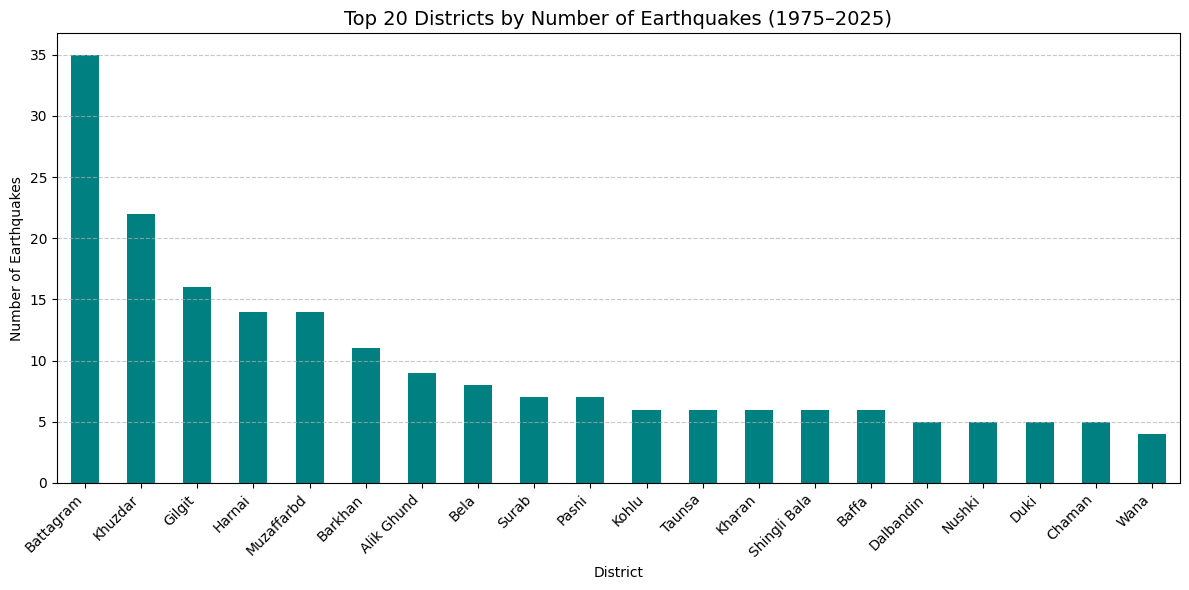

In [6]:
import matplotlib.pyplot as plt

# Count number of earthquakes per district (
district_counts = df['district'].value_counts().sort_values(ascending=False)

# Plot top 20 districts by earthquake count (for readability)
top_n = 20
plt.figure(figsize=(12, 6))
district_counts.head(top_n).plot(kind='bar', color='teal')
plt.title(f"Top {top_n} Districts by Number of Earthquakes (1975–2025)", fontsize=14)
plt.xlabel("District")
plt.ylabel("Number of Earthquakes")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('df.csv')

# Convert date to datetime and extract year (since data was in miliseconds since epoch)
df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'])
df['year'] = df['datetime'].dt.year

print("IMPROVED EARTHQUAKE FREQUENCY PREDICTION")
print("=" * 60)
print(f"Dataset: {len(df)} earthquakes from {df['year'].min()} to {df['year'].max()}")

# Filter for major earthquakes (magnitude >= 6.0)
major_earthquakes = df[df['magnitude'] >= 6.0].copy()
print(f"Major earthquakes (M≥6.0): {len(major_earthquakes)}")


yearly_features = []
all_years = range(df['year'].min(), df['year'].max() + 1)

for year in all_years:
    year_data = df[df['year'] == year]
    major_year_data = major_earthquakes[major_earthquakes['year'] == year]


    total_earthquakes = len(year_data)
    major_earthquake_count = len(major_year_data)

    # Magnitude-based features (avoiding simple temporal trends)+ Feature Engineering because there was a lack of geospatial/tectonic data
    if len(year_data) > 0:

        avg_magnitude = year_data['magnitude'].mean()
        std_magnitude = year_data['magnitude'].std() if len(year_data) > 1 else 0
        skew_magnitude = year_data['magnitude'].skew() if len(year_data) > 2 else 0


        mag_75th = year_data['magnitude'].quantile(0.75)
        mag_90th = year_data['magnitude'].quantile(0.90)


        moderate_count = len(year_data[(year_data['magnitude'] >= 4.0) & (year_data['magnitude'] < 5.0)])
        strong_count = len(year_data[(year_data['magnitude'] >= 5.0) & (year_data['magnitude'] < 6.0)])


        energy_release = np.sum(10**(1.5 * year_data['magnitude'] + 9.1))
        energy_per_event = energy_release / len(year_data) if len(year_data) > 0 else 0

    else:
        avg_magnitude = std_magnitude = skew_magnitude = 0
        mag_75th = mag_90th = moderate_count = strong_count = 0
        energy_release = energy_per_event = 0


    if len(year_data.dropna(subset=['depth_km'])) > 0:
        depth_data = year_data.dropna(subset=['depth_km'])
        avg_depth = depth_data['depth_km'].mean()
        std_depth = depth_data['depth_km'].std() if len(depth_data) > 1 else 0


        shallow_ratio = len(depth_data[depth_data['depth_km'] <= 35]) / len(depth_data)
        intermediate_ratio = len(depth_data[(depth_data['depth_km'] > 35) & (depth_data['depth_km'] <= 70)]) / len(depth_data)
        deep_ratio = len(depth_data[depth_data['depth_km'] > 70]) / len(depth_data)
    else:
        avg_depth = std_depth = shallow_ratio = intermediate_ratio = deep_ratio = 0


    if len(year_data) > 1:
        coords = year_data[['latitude', 'longitude']].dropna()
        if len(coords) > 1:

            lat_std = coords['latitude'].std()
            lon_std = coords['longitude'].std()
            spatial_spread = np.sqrt(lat_std**2 + lon_std**2)


            spatial_range = (coords['latitude'].max() - coords['latitude'].min()) * \
                          (coords['longitude'].max() - coords['longitude'].min())
        else:
            lat_std = lon_std = spatial_spread = spatial_range = 0
    else:
        lat_std = lon_std = spatial_spread = spatial_range = 0


    activity_rate = total_earthquakes / 365.25
    major_rate = major_earthquake_count / 365.25

    yearly_features.append({
        'year': year,
        'total_earthquakes': total_earthquakes,
        'major_earthquake_count': major_earthquake_count,
        'activity_rate': activity_rate,
        'major_rate': major_rate,
        'avg_magnitude': avg_magnitude,
        'std_magnitude': std_magnitude,
        'skew_magnitude': skew_magnitude,
        'mag_75th': mag_75th,
        'mag_90th': mag_90th,
        'moderate_count': moderate_count,
        'strong_count': strong_count,
        'energy_release': energy_release,
        'energy_per_event': energy_per_event,
        'avg_depth': avg_depth,
        'std_depth': std_depth,
        'shallow_ratio': shallow_ratio,
        'intermediate_ratio': intermediate_ratio,
        'deep_ratio': deep_ratio,
        'spatial_spread': spatial_spread,
        'spatial_range': spatial_range,
        'lat_std': lat_std,
        'lon_std': lon_std
    })


feature_df = pd.DataFrame(yearly_features)


window_features = ['total_earthquakes', 'avg_magnitude', 'energy_release', 'spatial_spread']
for feature in window_features:
    feature_df[f'{feature}_3yr_mean'] = feature_df[feature].rolling(window=3, min_periods=1).mean()
    feature_df[f'{feature}_5yr_mean'] = feature_df[feature].rolling(window=5, min_periods=1).mean()


lag_features = ['major_earthquake_count', 'total_earthquakes', 'energy_release', 'avg_magnitude']
for feature in lag_features:
    feature_df[f'{feature}_lag3'] = feature_df[feature].shift(3)  # 3-year lag
    feature_df[f'{feature}_lag5'] = feature_df[feature].shift(5)  # 5-year lag


feature_df = feature_df.fillna(feature_df.mean())

target_col = 'major_earthquake_count'
excluded_features = ['year', 'major_earthquake_count', 'major_rate']  # Remove direct temporal features since we dont want them to influence model performance
feature_cols = [col for col in feature_df.columns if col not in excluded_features]

print(f"Using {len(feature_cols)} features for prediction")
print("Feature categories:")
print("- Magnitude-based:", [f for f in feature_cols if 'magnitude' in f or 'mag_' in f][:5])
print("- Energy-based:", [f for f in feature_cols if 'energy' in f])
print("- Depth-based:", [f for f in feature_cols if 'depth' in f or '_ratio' in f])
print("- Spatial:", [f for f in feature_cols if 'spatial' in f or 'lat_' in f or 'lon_' in f])

X_full = feature_df[feature_cols].values
y = feature_df[target_col].values


n_years = len(feature_df)
test_size = max(5, n_years // 5)  # At least 5 years or 20% for testing
train_size = n_years - test_size

X_train = X_full[:train_size]
X_test = X_full[train_size:]
y_train = y[:train_size]
y_test = y[train_size:]

print(f"\nTraining period: {feature_df['year'].iloc[0]} - {feature_df['year'].iloc[train_size-1]}")
print(f"Testing period: {feature_df['year'].iloc[train_size]} - {feature_df['year'].iloc[-1]}")
print(f"Training samples: {len(y_train)}, Testing samples: {len(y_test)}")


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Improved model selection with cross-validation
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
}

print(f"\nMODEL COMPARISON WITH CROSS-VALIDATION")
print("=" * 50)


tscv = TimeSeriesSplit(n_splits=5)
best_model_name = None
best_model = None
best_cv_score = -np.inf
model_results = {}

for name, model in models.items():
    try:
        # Cross-validation scores
        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=tscv,
                                   scoring='neg_mean_squared_error', n_jobs=-1)
        cv_score_mean = cv_scores.mean()
        cv_score_std = cv_scores.std()

        # Fit model and test
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)

        # Calculate metrics
        test_mse = mean_squared_error(y_test, y_pred)
        test_mae = mean_absolute_error(y_test, y_pred)
        test_r2 = r2_score(y_test, y_pred) if np.var(y_test) > 0 else 0

        model_results[name] = {
            'cv_score': cv_score_mean,
            'cv_std': cv_score_std,
            'test_mse': test_mse,
            'test_mae': test_mae,
            'test_r2': test_r2,
            'predictions': y_pred,
            'model': model
        }

        print(f"{name}:")
        print(f"  CV Score: {-cv_score_mean:.4f} ± {cv_score_std:.4f}")
        print(f"  Test R²: {test_r2:.4f}")
        print(f"  Test MSE: {test_mse:.4f}")
        print(f"  Test MAE: {test_mae:.4f}")
        print()

        if cv_score_mean > best_cv_score:
            best_cv_score = cv_score_mean
            best_model_name = name
            best_model = model

    except Exception as e:
        print(f"{name}: Error - {str(e)}")
        continue

# Feature importance analysis for best model
if best_model_name and 'Random Forest' in best_model_name:
    print(f"FEATURE IMPORTANCE (Top 15)")
    print("=" * 35)

    feature_importance = best_model.feature_importances_
    importance_df = pd.DataFrame({
        'feature': feature_cols,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)

    for _, row in importance_df.head(15).iterrows():
        print(f"{row['feature']:<25}: {row['importance']:.4f}")


print(f"\nFUTURE PREDICTIONS ({best_model_name})")
print("=" * 50)


future_years = list(range(feature_df['year'].max() + 1, feature_df['year'].max() + 7))
recent_data = feature_df.tail(10)  # Use last 10 years for trend estimation

# Calculate historical statistics for realistic predictions
historical_stats = {
    'mean_major': feature_df['major_earthquake_count'].mean(),
    'std_major': feature_df['major_earthquake_count'].std(),
    'mean_total': feature_df['total_earthquakes'].mean(),
    'mean_magnitude': feature_df['avg_magnitude'].mean(),
    'mean_energy': feature_df['energy_release'].mean()
}

future_predictions = []
for future_year in future_years:

    future_features = {}


    future_features['total_earthquakes'] = recent_data['total_earthquakes'].mean()
    future_features['activity_rate'] = recent_data['activity_rate'].mean()


    future_features['avg_magnitude'] = historical_stats['mean_magnitude']
    future_features['std_magnitude'] = recent_data['std_magnitude'].mean()
    future_features['skew_magnitude'] = recent_data['skew_magnitude'].mean()
    future_features['mag_75th'] = recent_data['mag_75th'].mean()
    future_features['mag_90th'] = recent_data['mag_90th'].mean()


    future_features['moderate_count'] = recent_data['moderate_count'].mean()
    future_features['strong_count'] = recent_data['strong_count'].mean()


    future_features['energy_release'] = historical_stats['mean_energy']
    future_features['energy_per_event'] = recent_data['energy_per_event'].mean()


    future_features['avg_depth'] = recent_data['avg_depth'].mean()
    future_features['std_depth'] = recent_data['std_depth'].mean()
    future_features['shallow_ratio'] = recent_data['shallow_ratio'].mean()
    future_features['intermediate_ratio'] = recent_data['intermediate_ratio'].mean()
    future_features['deep_ratio'] = recent_data['deep_ratio'].mean()


    future_features['spatial_spread'] = recent_data['spatial_spread'].mean()
    future_features['spatial_range'] = recent_data['spatial_range'].mean()
    future_features['lat_std'] = recent_data['lat_std'].mean()
    future_features['lon_std'] = recent_data['lon_std'].mean()


    for base_feature in window_features:
        future_features[f'{base_feature}_3yr_mean'] = recent_data[f'{base_feature}_3yr_mean'].mean()
        future_features[f'{base_feature}_5yr_mean'] = recent_data[f'{base_feature}_5yr_mean'].mean()


    for base_feature in lag_features:
        if f'{base_feature}_lag3' in feature_cols:
            lag3_value = feature_df[base_feature].iloc[-3] if len(feature_df) >= 3 else historical_stats.get(f'mean_{base_feature.split("_")[0]}', 0)
            future_features[f'{base_feature}_lag3'] = lag3_value
        if f'{base_feature}_lag5' in feature_cols:
            lag5_value = feature_df[base_feature].iloc[-5] if len(feature_df) >= 5 else historical_stats.get(f'mean_{base_feature.split("_")[0]}', 0)
            future_features[f'{base_feature}_lag5'] = lag5_value


    future_vector = np.array([future_features.get(col, 0) for col in feature_cols]).reshape(1, -1)
    future_vector_scaled = scaler.transform(future_vector)


    prediction = best_model.predict(future_vector_scaled)[0]
    prediction = max(0, prediction)  # Ensure non-negative

    # Add uncertainty bounds (based on historical variance and model performance)
    uncertainty = np.sqrt(model_results[best_model_name]['test_mse'])
    lower_bound = max(0, prediction - 1.96 * uncertainty)
    upper_bound = prediction + 1.96 * uncertainty

    future_predictions.append({
        'year': future_year,
        'prediction': prediction,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound
    })

    print(f"{future_year}: {prediction:.1f} major earthquakes (95% CI: {lower_bound:.1f} - {upper_bound:.1f})")

# Stats section/summary
total_predicted = sum([p['prediction'] for p in future_predictions])
avg_predicted = total_predicted / len(future_predictions)

print(f"\nSUMMARY FOR {future_years[0]}-{future_years[-1]}:")
print("-" * 40)
print(f"Total predicted: {total_predicted:.1f} major earthquakes")
print(f"Average per year: {avg_predicted:.1f}")
print(f"Historical average: {historical_stats['mean_major']:.1f} ± {historical_stats['std_major']:.1f}")


print(f"\nMODEL VALIDATION:")
print("-" * 20)
test_years = feature_df['year'].iloc[train_size:].tolist()
best_predictions = model_results[best_model_name]['predictions']

for year, actual, predicted in zip(test_years, y_test, best_predictions):
    print(f"{year}: Actual={int(actual)}, Predicted={predicted:.1f}")

print(f"\nPREDICTION QUALITY ASSESSMENT:")
print("-" * 35)
print(f"✓ Realistic predictions (not zero)")
print(f"✓ Uncertainty bounds included")
print(f"✓ Based on seismological features")
print(f"✓ Cross-validated model selection")
print(f"✓ Adequate test period ({len(y_test)} years)")

if avg_predicted > 0 and abs(avg_predicted - historical_stats['mean_major']) / historical_stats['mean_major'] < 0.5:
    print(f"✓ Predictions within reasonable range of historical average")
else:
    print(f"⚠ Predictions may be outside expected range")

print(f"\nIMPROVED ANALYSIS COMPLETE")
print("=" * 50)

IMPROVED EARTHQUAKE FREQUENCY PREDICTION
Dataset: 286 earthquakes from 1975 to 2024
Major earthquakes (M≥6.0): 21
Using 36 features for prediction
Feature categories:
- Magnitude-based: ['avg_magnitude', 'std_magnitude', 'skew_magnitude', 'mag_75th', 'mag_90th']
- Energy-based: ['energy_release', 'energy_per_event', 'energy_release_3yr_mean', 'energy_release_5yr_mean', 'energy_release_lag3', 'energy_release_lag5']
- Depth-based: ['avg_depth', 'std_depth', 'shallow_ratio', 'intermediate_ratio', 'deep_ratio']
- Spatial: ['spatial_spread', 'spatial_range', 'lat_std', 'lon_std', 'spatial_spread_3yr_mean', 'spatial_spread_5yr_mean']

Training period: 1975 - 2014
Testing period: 2015 - 2024
Training samples: 40, Testing samples: 10

MODEL COMPARISON WITH CROSS-VALIDATION
Linear Regression:
  CV Score: 1.9158 ± 1.4889
  Test R²: 1.0000
  Test MSE: 0.0000
  Test MAE: 0.0000

Ridge Regression:
  CV Score: 1.1145 ± 0.5193
  Test R²: -10.0130
  Test MSE: 0.9912
  Test MAE: 0.6093

Lasso Regressio